# MessMaster: the Curse of the Muffin-Faced Dog (part 2)

<div>
<img src="media/domino_meme.png" width="400"/>
</div>

Welcome back to the quest of MessMaster! 

This week, we will continue to help Boltzmann differentiate Chihuahuas and blueberry muffins, but with fancier models (no longer just linear)!

<div>
<img src="../lab2/media/chihuahua_muffin.png" width="400"/>
</div>

Specifically we will use the following concepts:

- Backprop: implementation and visualization
- MLP: decision boundary and contrast with linear models
- Optimization: Comparing SGD v.s. Adam

A friend has helped us found a separable 2D embedding of Chihuahuas and blueberry muffins.
However, it is not linearly separable!

<div>
<img src="secret/data/xor_pattern_label.png" width="400"/>
</div>


We will train a MLP to help with this!


#### 1. ManualGrad: handcrafted gradients, artisanal machine learning

Backprop is the process of computing the gradient of the loss function w.r.t. all the parameters from multiple stages of nonlinear transformations of the input. 

It is efficient both in terms of computation and memory and is universally used for computing the gradient and in well-implemented in many widely used tools (e.g., ```torch.autograd```). 

Today, we will implement backprop by hand  for a 2-layer MLP because it's a good exercise for understanding backprop :) 

First we will load the data and split it into train/val/test sets.

**Q1a.** Why is it important to have validation and test sets?

Answer: 

We can use the validation set to tune the hyperparameters and the test set to evaluate the performance of the model. 

We need the test set, which is separate from both the training and validation sets, to evaluate the performance of the model on unseen data.

In [1]:
# For reproducibility
RANDOM_SEED = 10011  # postal code of CDS <3

import torch
from sklearn.model_selection import train_test_split
import pandas as pd

# load data
df = pd.read_csv("secret/data/xor_pattern.csv")
X = df[["x1", "x2"]].values  # Extract features
y = df["y"].values  #

# train-val-test split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_SEED)
# TODO: what is the train-val-test split ratio?

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

**Q1b.** Implement the CEL loss function for binary classification. What is its connection to energy?

Answer: For cross entropy loss, the energy is the negative log likelihood of the correct class.

$L_{\text{CE}}(y, p_{\hat{y}}) = - \log p_{\hat{y}}(\hat{y}=y)$.

In code, we first find the probability of the correct class by indexing into the probability tensor from softmax.

Then we compute the mean of the negative log likelihood across all examples.



In [2]:
def loss_fn(p_y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the cross-entropy loss (negative log likelihood) of a prediction.
    p_y_hat: probability of each class, shape (N, 2)
    y: true class, shape (N,)
    returns: loss, shape (1,)
    """
    # TODO: implement the loss function
    # step 1: fine the probability of the correct class
    correct_class_loc = [range(y.shape[0]), y]
    correct_class_prob = p_y_hat[correct_class_loc]
    # step 2: compute the mean of the negative log likelihood across all examples
    nll = -torch.mean(torch.log(correct_class_prob))
    return nll
    # return 0 

**Q1c.** 

i. What does derivative/gradient tells us about a function? (What does positive/negative gradient mean?)

ii. Why is it useful for optimization?

iii. What is chain rule?

Answer: 

i. The derivative of a function tells us the rate of change of the function. A positive derivative means the function is increasing with the parameter, and a negative derivative means the function is decreasing with the parameter.

ii. It is useful for optimization because we can use it to find the minimum or maximum of a function.

iii. The chain rule is a rule in calculus for differentiating the composition of two functions. If $f(x) = h(g(x))$, then $f'(x) = h'(g(x)) * g'(x)$.

**Q1d.**

We are going to implement a two-layer MLP with ReLU activation and softmax output. Training with gradient descent.

First layer: $z_1 = h_1(x) = \sigma(W_1 x + b_1)=\sigma(a_1)$

Second layer: $z_2 = h_2(x) = W_2 z_1 + b_2$

Softmax: $\hat{p} = \text{softmax}(z_2) = \frac{e^{z_2}}{\sum_{j=1}^{2} e^{z_{2j}}}$

Loss function: $L(y, p_{\hat{y}}) = \text{L}_{\text{ce}}(y, p_{\hat{y}}) = - \log \hat{p}(\hat{y}=y)$

Consider computing the gradient of the loss function with respect to the parameters.

Let's focus on the first layer. What is $\frac{\partial L}{\partial W_1}$?

You may use the fact that $\frac{\partial L}{\partial z_2} = \hat{p} - y$ and that $\sigma'(a) = 1(\sigma(a) > 0)$, where $1(\cdot)$ is the indicator function.


Answer:

$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial z_2} \frac{\partial z_2}{\partial z_1} \frac{\partial z_1}{\partial W_1}$

$\frac{\partial z_2}{\partial z_1} = W_2$

$\frac{\partial z_1}{\partial W_1} = \text{diag} (1(W_1 x + b_1 > 0)) x^\top$




Training (todo: fill in gradients)

In [3]:
# Initialize weights
W1 = torch.randn(2, 10, requires_grad=False) * 0.01
b1 = torch.zeros(10, requires_grad=False)
W2 = torch.randn(10, 2, requires_grad=False) * 0.01
b2 = torch.zeros(2, requires_grad=False)

learning_rate = 0.1
epochs = 10000

for epoch in range(epochs):
    # =================== Forward pass ===================
    # First layer: z1 = W1 * X + b1
    z1 = X_train_tensor @ W1 + b1  # Shape: (N, h)  [batch_size, hidden_dim]

    # Apply activation function: a1 = ReLU(z1)
    a1 = torch.relu(z1)  # Shape: (N, h)

    # Second layer: z2 = W2 * a1 + b2
    z2 = a1 @ W2 + b2  # Shape: (N, k)  [batch_size, num_classes]

    # Apply softmax to get probabilities: p_hat = softmax(z2)
    p_hat = torch.softmax(z2, dim=1)   # Shape: (N, k)

    # =================== Compute Loss ===================
    # PyTorch's CrossEntropyLoss automatically applies softmax inside,
    # so we should pass raw logits (z2), not softmax probabilities (p_hat)
    loss = loss_fn(p_hat, y_train_tensor)  # Scalar loss value

    # =================== Backpropagation ===================

    # Step 1: Compute gradient of loss w.r.t. logits (z2)
    # Cross-entropy loss with softmax:
    #   L = - (1/N) * sum(y * log(p_hat))
    # Derivative:
    #   dL/dz2 = (p_hat - y) / N
    # Shape: (N, k) [Same as z2]
    y_one_hot = torch.nn.functional.one_hot(y_train_tensor, num_classes=p_hat.shape[1]).float()  # Shape: (N, k)
    dL_dz2 = (p_hat - y_one_hot) / y_train_tensor.shape[0]  # Normalize by batch size

    # Step 2: Compute gradient of loss w.r.t. W2 and b2
    # Using chain rule: dL/dW2 = (dL/dz2) * (dz2/dW2)
    #   dz2/dW2 = a1^T
    #   dL/dW2 = a1^T @ dL/dz2
    # Shape: (h, k) [Same as W2]
    dL_dW2 = a1.T @ dL_dz2

    # Gradient of loss w.r.t. b2:
    #   dL/db2 = sum(dL/dz2) along batch axis
    # Shape: (k,) [Same as b2]
    dL_db2 = torch.sum(dL_dz2, dim=0)

    # Step 3: Compute gradient of loss w.r.t. activations (a1)
    #   dL/da1 = (dL/dz2) * (dz2/da1)
    #   dz2/da1 = W2^T
    #   dL/da1 = dL/dz2 @ W2^T
    # Shape: (N, h) [Same as a1]
    dL_da1 = dL_dz2 @ W2.T # TODO: fill in this

    # Step 4: Compute gradient of loss w.r.t. pre-activation (z1)
    # Using chain rule: dL/dz1 = (dL/da1) * (da1/dz1)
    # ReLU derivative:
    #   da1/dz1 = 1 if z1 > 0, else 0
    # Shape: (N, h) [Same as z1]
    dL_dz1 = dL_da1 * (z1 > 0).float() # TODO: fill in this

    # Step 5: Compute gradient of loss w.r.t. W1 and b1
    # Using chain rule: dL/dW1 = (dL/dz1) * (dz1/dW1)
    #   dz1/dW1 = X^T
    #   dL/dW1 = X^T @ dL/dz1
    # Shape: (d, h) [Same as W1]
    dL_dW1 = X_train_tensor.T @ dL_dz1 # TODO: fill in this

    # Gradient of loss w.r.t. b1:
    #   dL/db1 = sum(dL/dz1) along batch axis
    # Shape: (h,) [Same as b1]
    dL_db1 = torch.sum(dL_dz1, dim=0)

    # Gradient update (SGD step)
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.6931
Epoch 10: Loss = 0.6911
Epoch 20: Loss = 0.6903
Epoch 30: Loss = 0.6900
Epoch 40: Loss = 0.6899
Epoch 50: Loss = 0.6898
Epoch 60: Loss = 0.6897
Epoch 70: Loss = 0.6896
Epoch 80: Loss = 0.6896
Epoch 90: Loss = 0.6895
Epoch 100: Loss = 0.6893
Epoch 110: Loss = 0.6891
Epoch 120: Loss = 0.6889
Epoch 130: Loss = 0.6887
Epoch 140: Loss = 0.6883
Epoch 150: Loss = 0.6879
Epoch 160: Loss = 0.6874
Epoch 170: Loss = 0.6867
Epoch 180: Loss = 0.6858
Epoch 190: Loss = 0.6847
Epoch 200: Loss = 0.6833
Epoch 210: Loss = 0.6816
Epoch 220: Loss = 0.6795
Epoch 230: Loss = 0.6768
Epoch 240: Loss = 0.6735
Epoch 250: Loss = 0.6694
Epoch 260: Loss = 0.6646
Epoch 270: Loss = 0.6587
Epoch 280: Loss = 0.6518
Epoch 290: Loss = 0.6438
Epoch 300: Loss = 0.6346
Epoch 310: Loss = 0.6242
Epoch 320: Loss = 0.6126
Epoch 330: Loss = 0.5995
Epoch 340: Loss = 0.5850
Epoch 350: Loss = 0.5688
Epoch 360: Loss = 0.5510
Epoch 370: Loss = 0.5315
Epoch 380: Loss = 0.5107
Epoch 390: Loss = 0.4888
Epoch 400: 

**Visualization**

Now let's visualize the decision boundary of the trained MLP.

Can linear models learn this decision boundary?

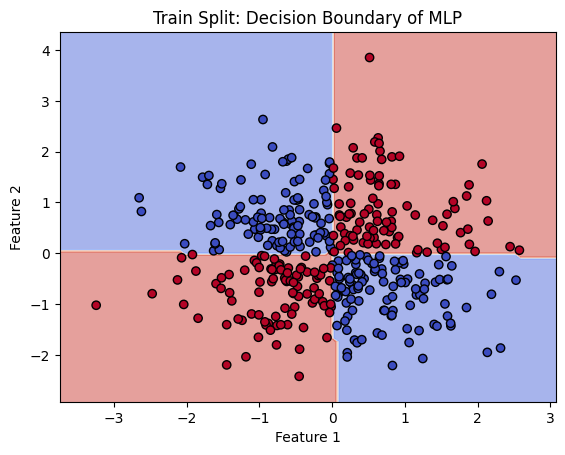

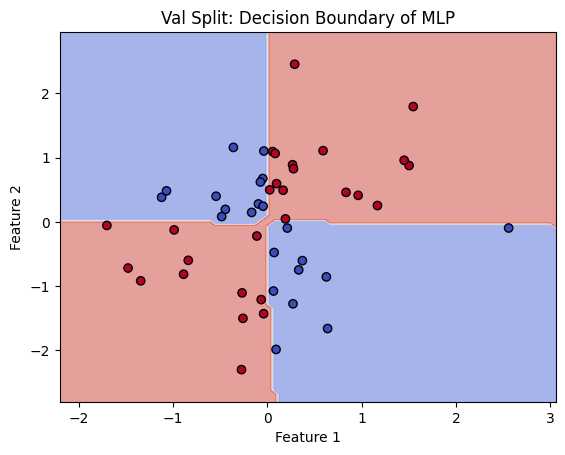

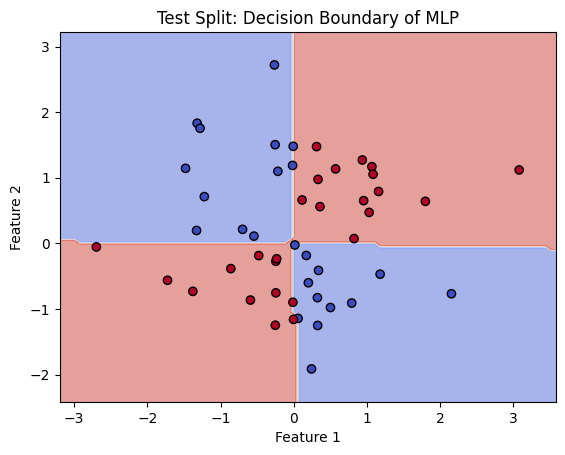

In [4]:
from util import plot_decision_boundary
# Example usage:
plot_decision_boundary(W1, b1, W2, b2, X_train_tensor.numpy(), y_train_tensor.numpy(), split="Train")
plot_decision_boundary(W1, b1, W2, b2, X_val_tensor.numpy(), y_val_tensor.numpy(), split="Val")
plot_decision_boundary(W1, b1, W2, b2, X_test_tensor.numpy(), y_test_tensor.numpy(), split="Test")

#### 2. Optimizers: Adam v.s. SGD

In [5]:
import torch
import torch.nn.functional as F

W1.requires_grad = True
W2.requires_grad = True
b1.requires_grad = True
b2.requires_grad = True
# Hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.1 #1e-3

# Initialize weights with Xavier (Glorot) initialization
torch.manual_seed(RANDOM_SEED)  # For reproducibility
torch.nn.init.xavier_uniform_(W1)
torch.nn.init.xavier_uniform_(W2)
b1.data.fill_(0)
b2.data.fill_(0)

# Define two optimizers: SGD and Adam
optimizer_sgd = torch.optim.SGD([W1, b1, W2, b2], lr=learning_rate)
optimizer_adam = torch.optim.Adam([W1, b1, W2, b2], lr=learning_rate)

# Learning rate schedulers (optional)
# scheduler_sgd = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size=20, gamma=0.5)  # Decay every 20 epochs
# scheduler_adam = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=20, gamma=0.5)

# Store loss & lr history
loss_history_sgd, loss_history_adam = [], []
lr_history_sgd, lr_history_adam = [], []

# Training loop for both optimizers
for optimizer_name, optimizer, loss_history, lr_history in [
    ("SGD", optimizer_sgd, loss_history_sgd, lr_history_sgd),
    ("Adam", optimizer_adam, loss_history_adam, lr_history_adam),
]:
    print(f"\nTraining with {optimizer_name}...\n")

    # Reset weights for fair comparison
    torch.nn.init.xavier_uniform_(W1)
    torch.nn.init.xavier_uniform_(W2)
    b1.data.fill_(0)
    b2.data.fill_(0)

    for epoch in range(epochs):
        # =================== Forward pass ===================
        z1 = X_train_tensor @ W1 + b1
        a1 = torch.relu(z1)
        z2 = a1 @ W2 + b2
        loss = F.cross_entropy(z2, y_train_tensor)

        # =================== Backward pass ===================
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Save loss & learning rate
        loss_history.append(loss.item())

        lr_history.append(optimizer.param_groups[0]["lr"])  # Extract current lr

        # Learning rate decay (if scheduler exists)
        # scheduler.step()

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(
                f"{optimizer_name} - Epoch {epoch}: Loss = {loss.item():.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}"
            )


Training with SGD...

SGD - Epoch 0: Loss = 0.7869, LR = 0.100000
SGD - Epoch 10: Loss = 0.6714, LR = 0.100000
SGD - Epoch 20: Loss = 0.6108, LR = 0.100000
SGD - Epoch 30: Loss = 0.5689, LR = 0.100000
SGD - Epoch 40: Loss = 0.5383, LR = 0.100000
SGD - Epoch 50: Loss = 0.5104, LR = 0.100000
SGD - Epoch 60: Loss = 0.4834, LR = 0.100000
SGD - Epoch 70: Loss = 0.4571, LR = 0.100000
SGD - Epoch 80: Loss = 0.4320, LR = 0.100000
SGD - Epoch 90: Loss = 0.4081, LR = 0.100000

Training with Adam...

Adam - Epoch 0: Loss = 0.8531, LR = 0.100000
Adam - Epoch 10: Loss = 0.3232, LR = 0.100000
Adam - Epoch 20: Loss = 0.1262, LR = 0.100000
Adam - Epoch 30: Loss = 0.0716, LR = 0.100000
Adam - Epoch 40: Loss = 0.0534, LR = 0.100000
Adam - Epoch 50: Loss = 0.0440, LR = 0.100000
Adam - Epoch 60: Loss = 0.0381, LR = 0.100000
Adam - Epoch 70: Loss = 0.0340, LR = 0.100000
Adam - Epoch 80: Loss = 0.0307, LR = 0.100000
Adam - Epoch 90: Loss = 0.0279, LR = 0.100000


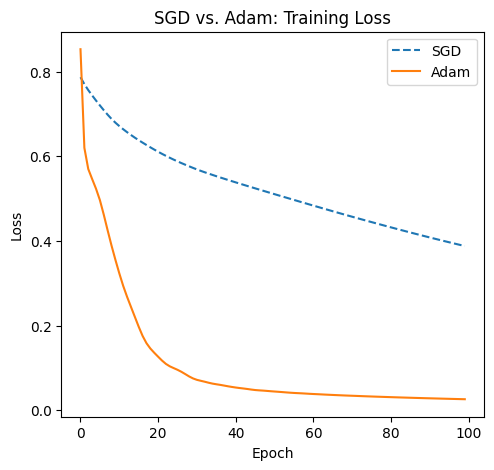

In [6]:
from util import plot_loss
plot_loss(loss_history_sgd, loss_history_adam)